In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import os

In [8]:
# Paths to your dataset
train_dir = 'C:/Users/soujanya/Downloads/New/DFU/organized_dataset/train'
test_dir = 'C:/Users/soujanya/Downloads/New/DFU/organized_dataset/test'

In [9]:
# Image dimensions and settings
img_height, img_width = 224, 224
batch_size = 32

In [10]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    shear_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1
)


In [11]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [12]:
# Data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

Found 726 images belonging to 2 classes.


In [13]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 249 images belonging to 2 classes.


In [14]:
# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

Class Weights: {0: 1.6962616822429906, 1: 0.708984375}


In [15]:
# Load base MobileNetV2
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze the convolutional base

In [16]:
# Build the model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')  # For binary classification
])

In [17]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [18]:
# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator,
    class_weight=class_weights_dict,
    callbacks=[early_stopping]
)

Epoch 1/20
23/23 [==============================] - 19s 750ms/step - loss: 0.1871 - accuracy: 0.9256 - val_loss: 0.0729 - val_accuracy: 0.9679
Epoch 2/20
23/23 [==============================] - 20s 862ms/step - loss: 0.0808 - accuracy: 0.9697 - val_loss: 0.0487 - val_accuracy: 0.9839
Epoch 3/20
23/23 [==============================] - 19s 843ms/step - loss: 0.0502 - accuracy: 0.9780 - val_loss: 0.0469 - val_accuracy: 0.9759
Epoch 4/20
23/23 [==============================] - 19s 836ms/step - loss: 0.0370 - accuracy: 0.9862 - val_loss: 0.0390 - val_accuracy: 0.9799
Epoch 5/20
23/23 [==============================] - 19s 832ms/step - loss: 0.0314 - accuracy: 0.9835 - val_loss: 0.0250 - val_accuracy: 0.9880
Epoch 6/20
23/23 [==============================] - 19s 825ms/step - loss: 0.0301 - accuracy: 0.9904 - val_loss: 0.0228 - val_accuracy: 0.9920
Epoch 7/20
23/23 [==============================] - 19s 844ms/step - loss: 0.0198 - accuracy: 0.9931 - val_loss: 0.0188 - val_accuracy: 0.9960

In [20]:
# Save the model
model.save('dfu_transfer_mobilenet_model.h5')


In [21]:
# Evaluate the model
print("\nEvaluating on test set...")
test_generator.reset()
predictions = model.predict(test_generator)
y_pred = (predictions > 0.5).astype(int).flatten()
y_true = test_generator.classes



Evaluating on test set...
8/8 [==============================] - 4s 462ms/step


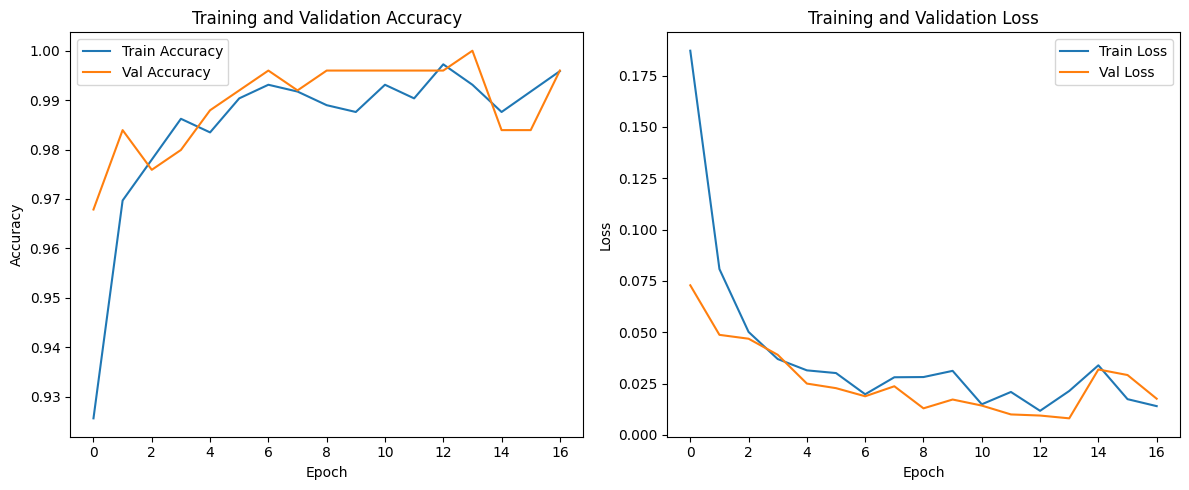

In [22]:
# Accuracy plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [23]:
report = classification_report(y_true, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
print("\nClassification Report as Table:")
print(df_report.round(2))



Classification Report as Table:
              precision  recall  f1-score  support
0                   1.0     1.0       1.0    214.0
1                   1.0     1.0       1.0     35.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0    249.0
weighted avg        1.0     1.0       1.0    249.0
